In [1]:
from tiff_to_3d_array import tiff_to_3d_array as t3a
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display, HTML
import imageio
from PIL import Image as PILImage
from scipy.optimize import curve_fit
import base64


# **Problem 1** #

## a) ##

Tracking video saved as media/tracked_particles.mp4
Animated GIF saved as media/tracked_particles.gif



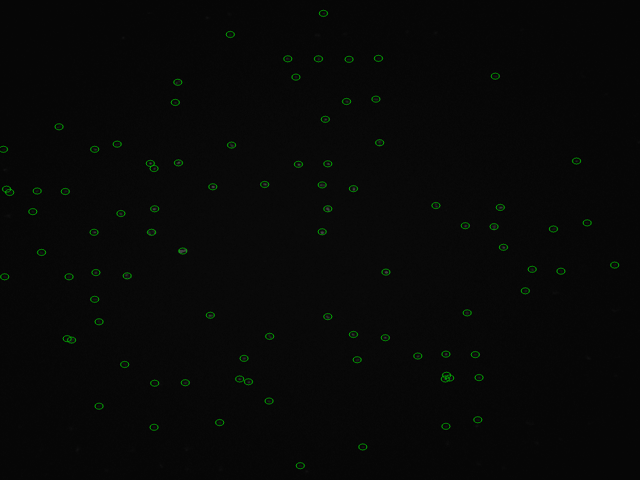

In [2]:
# Experimenting with opencv

def test_tracking():
    # Load frames from TIFF and normalize to 8-bit
    frames = t3a("media/ConfinedDNAPlasmids.tif")
    frames = (frames / frames.max() * 255).astype(np.uint8)

    # Define parameters
    threshold_value = 13
    min_particle_width = 4
    max_particle_width = 25

    # Store particle positions and GIF frames
    tracked_positions = []
    gif_frames = []

    # Video and GIF setup
    output_video_path = "media/tracked_particles.mp4"
    output_gif_path = "media/tracked_particles.gif"
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 20
    frame_height, frame_width = frames.shape[1], frames.shape[2]
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    for i, frame in enumerate(frames):
        frame_color = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        
        # Thresholding and contour detection
        _, binary = cv2.threshold(frame, threshold_value, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        current_positions = []
        
        for contour in contours:
            c_area = cv2.contourArea(contour)
            if min_particle_width**2 <= c_area <= max_particle_width**2:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx, cy = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
                    current_positions.append((cx, cy))
                    cv2.circle(frame_color, (cx, cy), 7, (0, 255, 0), 1)

        tracked_positions.append(current_positions)
        out.write(frame_color)
        
        # Convert frame to RGB for GIF and resize if needed
        gif_frame = cv2.cvtColor(frame_color, cv2.COLOR_BGR2RGB)
        gif_frames.append(gif_frame)

    # Release video writer
    out.release()

    # Create GIF (reduce size for better PDF compatibility)


    # Resize frames and save as GIF
    resized_frames = [PILImage.fromarray(frame).resize((640, 480)) for frame in gif_frames]
    resized_frames[0].save(
        output_gif_path,
        save_all=True,
        append_images=resized_frames[1:],
        duration=1000//fps,  # Match video FPS
        loop=0
    )

    print(f"Tracking video saved as {output_video_path}")
    print(f"Animated GIF saved as {output_gif_path}")

test_tracking()

with open("media/tracked_particles.gif", "rb") as gif_file:
    gif_data = base64.b64encode(gif_file.read()).decode("utf-8")
HTML(f'<img src="data:image/gif;base64,{gif_data}">')

<img src="" alt="Alt Text" width="500">

Tracking video saved as media/tracked_particle.mp4
Animated GIF saved as media/tracked_particle.gif


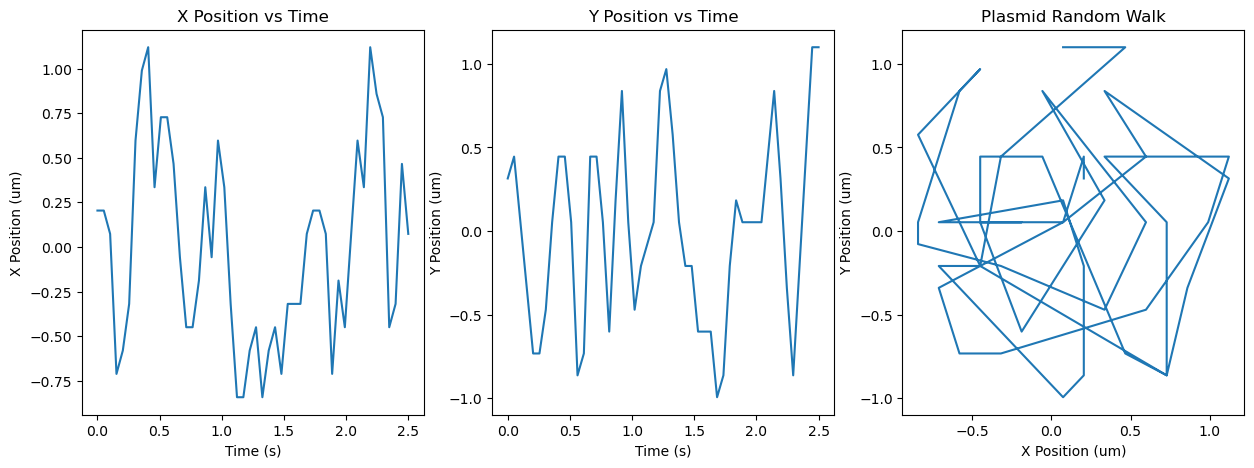

In [3]:
# Track a single particle and plot its position over time

# Manually tuned parameters
threshold_value = 13
min_particle_width = 4
max_particle_width = 25
well_loc = (523, 673)
well_rad = 30
p_size = (min_particle_width, max_particle_width)


def track_particle(filepath: str, well_loc: tuple, well_rad: int, threshold_value: int, 
                   p_size: tuple, output_graphics: bool) -> np.array:
    """
    Returns a 2d numpy array of the particle's x and y positions over time.
    Generates and displays tracking visualization if output_graphics=True.
    """
    
    # Define parameters
    min_particle_width, max_particle_width = p_size
    well_x, well_y = well_loc

    # Load and normalize frames
    frames = t3a(filepath)
    frames = (frames / frames.max() * 255).astype(np.uint8)

    # Crop to well region
    frames = frames[:, well_y - well_rad:well_y + well_rad, 
                    well_x - well_rad:well_x + well_rad]

    # Initialize outputs
    p_positions = np.array([])
    gif_frames = []

    if output_graphics:
        # Video setup
        output_video_path = "media/tracked_particle.mp4"
        output_gif_path = "media/tracked_particle.gif"
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = 20
        frame_height, frame_width = frames.shape[1], frames.shape[2]
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    for frame in frames:
        frame_color = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR) if output_graphics else None
        
        # Processing pipeline
        _, binary = cv2.threshold(frame, threshold_value, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            c_area = cv2.contourArea(contour)
            if min_particle_width**2 <= c_area <= max_particle_width**2:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx, cy = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
                    p_positions = np.append(p_positions, [cx, cy])
                    if output_graphics:
                        cv2.circle(frame_color, (cx, cy), 7, (0, 255, 0), 1)

        if output_graphics:
            # Write to video
            out.write(frame_color)
            
            # Prepare GIF frame (resize to 50% for smaller file size)
            rgb_frame = cv2.cvtColor(frame_color, cv2.COLOR_BGR2RGB)
            pil_frame = PILImage.fromarray(rgb_frame).resize(
                (frame_width//2, frame_height//2),  # Half size for PDF compatibility
                resample=PILImage.Resampling.LANCZOS
            )
            gif_frames.append(pil_frame)

    if output_graphics:
        # Finalize video
        out.release()
        print(f"Tracking video saved as {output_video_path}")

        # Save GIF
        gif_frames[0].save(
            output_gif_path,
            save_all=True,
            append_images=gif_frames[1:],
            duration=1000//fps,  # ms per frame
            loop=0,
            optimize=True
        )
        print(f"Animated GIF saved as {output_gif_path}")

    return p_positions.reshape(-1, 2)

postions = track_particle("media/ConfinedDNAPlasmids.tif", well_loc, well_rad, threshold_value, p_size, output_graphics=True)

# Extracting, centering, and scaling x and y positions
x_positions = postions[:, 0] / 7.64  # 1 um = 7.64 pixels
x_positions -= np.mean(x_positions)
y_positions = postions[:, 1] / 7.64  # 1 um = 7.64 pixels
y_positions -= np.mean(y_positions)

# Plotting x and y positions vs time
t_arr = np.linspace(0, 2.5, len(x_positions))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(t_arr, x_positions)
axes[0].set_title("X Position vs Time")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("X Position (um)")

axes[1].plot(t_arr, y_positions)
axes[1].set_title("Y Position vs Time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Y Position (um)")

axes[2].plot(x_positions, y_positions)
axes[2].set_title("Plasmid Random Walk")
axes[2].set_xlabel("X Position (um)")
axes[2].set_ylabel("Y Position (um)")
plt.show()

with open("media/tracked_particle.gif", "rb") as gif_file:
    gif_data = base64.b64encode(gif_file.read()).decode("utf-8")
HTML(f'<img src="data:image/gif;base64,{gif_data}" style="width: 300px; height: auto;">')

## b) ##

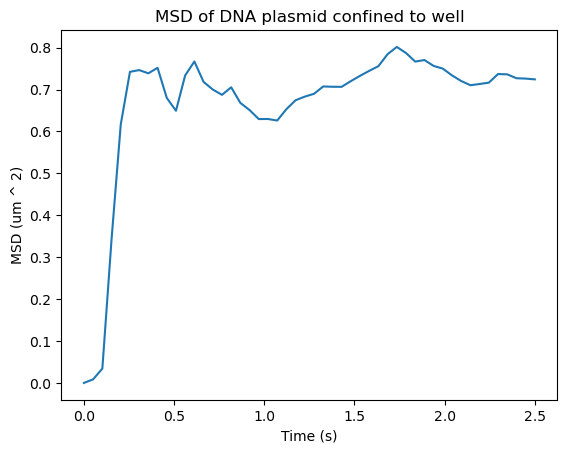

In [4]:
# Calculate and graph MSD

def msd(x, y):
    """
    Returns an array of msd values for a given x and y position array.
    """
    # Starting x and y
    x_0 = x[0]
    y_0 = y[0]
    # Difference in x and y from start
    x_d = x - x_0
    y_d = y - y_0

    msd_arr = np.array([])

    # Calculate the msd for each time interval.
    # This is taken as the mean of the squared displacement for every data point leading up to the current time
    for i in range(1, len(x) + 1):
        if i == len(x):
            msd_arr = np.append(msd_arr, np.mean(x_d ** 2 + y_d ** 2))
        else:
            msd_arr = np.append(msd_arr, np.mean(x_d[:i] ** 2 + y_d[:i] ** 2))

    return msd_arr

constrained_msd = msd(x_positions, y_positions)

# Plotting MSD over time
plt.plot(t_arr, constrained_msd)
plt.title('MSD of DNA plasmid confined to well')
plt.xlabel('Time (s)')
plt.ylabel('MSD (um ^ 2)')
plt.show()

This curve is more or less what I expected for confined diffusion as the maximum displacement from $r_0$ is limited by the well size thus causing the MSD to stabilize or increase much slower rather than increase linearly with time.

## c) ##

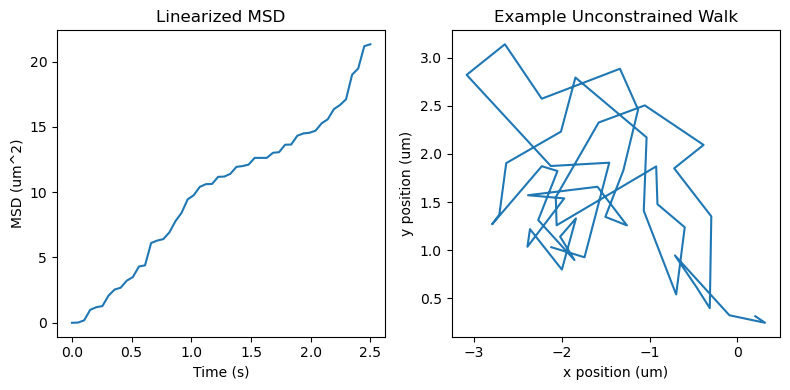

In [5]:
# MSD is non-linear with time so I will attempt to convert the constrained motion to a linear MSD
# This will be done by taking the displacement between steps and randomly assigning direction to try to cancel out the effects of constraint.
# This will allow us to use the 2D diffusion formula that is linear in t to find D, hopefully leading to a better estimation of radius.

N = 1000

def linearized_msd(x, y, n):
    """
    Returns an array of MSD values. n will determine how many randomized walks are averaged over
    to obtain the final MSD distribution. Also creates global varibles that store the most
    recent random walk for plotting.
    """
    global x_walk
    global y_walk
    
    # Starting x and y
    x_0 = x[0]
    y_0 = y[0]

    # initializing arrays
    x_walks = np.array([])
    y_walks = np.array([])
    msd_arr = np.array([0])
    
    # generator loop
    for j in range(n):
        x_new = np.array([x_0])
        y_new = np.array([y_0])
        
        # randomizing the walk
        for i in range(1, len(x)):
            # calculate the magnitude of the step size
            dx = x[i] - x[i-1]
            dy = y[i] - y[i-1]
            dr = np.sqrt(dx **2 + dy **2)
            # assign random angle for step
            phi = np.random.uniform(0, 2 * np.pi)

            # calculate new x and y components of step (conserving step magnitude)
            dx_new = np.cos(phi) * dr
            dy_new = np.sin(phi) * dr

            # appending new steps to array
            x_new = np.append(x_new, x_new[i-1] + dx_new)
            y_new = np.append(y_new, y_new[i-1] + dy_new)

        # after walk has finished append to array before running again
        x_walks = np.append(x_walks, x_new)
        y_walks = np.append(y_walks, y_new)

    # reshape to make easier to work with
    x_walks = x_walks.reshape((n, -1))
    y_walks = y_walks.reshape((n, -1))

    # assign walks to global variables for plotting
    x_walk, y_walk = x_new, y_new

    for k in range(1, len(x)):
        # calculate at each time value, calculate the msd from the origin across all simulations
        msd_t = np.mean((x_walks[:, k] - x_0) ** 2 + (y_walks[:, k] - y_0) ** 2)
        msd_arr = np.append(msd_arr, msd_t)

    return msd_arr

linz_msd = linearized_msd(x_positions, y_positions, N)

# Plotting MSD over time
fig, axes = plt.subplots(1, 2, tight_layout=True, figsize=(8,4))

axes[0].plot(t_arr, linz_msd)
axes[0].set_title('Linearized MSD')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('MSD (um^2)')

axes[1].plot(x_walk, y_walk)
axes[1].set_title('Example Unconstrained Walk')
axes[1].set_xlabel('x position (um)')
axes[1].set_ylabel('y position (um)')

plt.show()

In [6]:
# Calculate D from linearized MSD and linear region of constrained MSD to compare

# fit function
def msd_2d(t, D):
    return 4 * D * t

# fit data to find D
def calculate_D(msd):
    p, p_cov = curve_fit(msd_2d, t_arr[:len(msd)], msd)
    return p[0]

# (most) linear region of constrained diffusion
lin_con_msd = constrained_msd[:7]

D_con = calculate_D(lin_con_msd)
D_lin = calculate_D(linz_msd)

# correct for units
D_con *= 1E-12
D_lin *= 1E-12

print(D_con, D_lin)

eta = 1E-3
T = 22.5 + 273.15
k_b = 1.38E-23

r_con = k_b * T / (6 * np.pi * eta * D_con)
r_lin = k_b * T / (6 * np.pi * eta * D_lin)

print(r_con, r_lin)

6.333864344896196e-13 1.98814696610967e-12
3.4173313362791014e-07 1.0886978414834499e-07


The diffusion coefficient obtained from the linear portion of constrained diffusion is: $D_{con} = 6.33 \times 10^{-13} \quad m^2 /s$. The diffusion coefficient obtained from my linearization method is: $D_{linz} = 1.95 \times 10^{-12} \quad m^2 /s$.

## d) ##

Animated GIF saved as media/selected_particles.gif
(50, 48, 2)


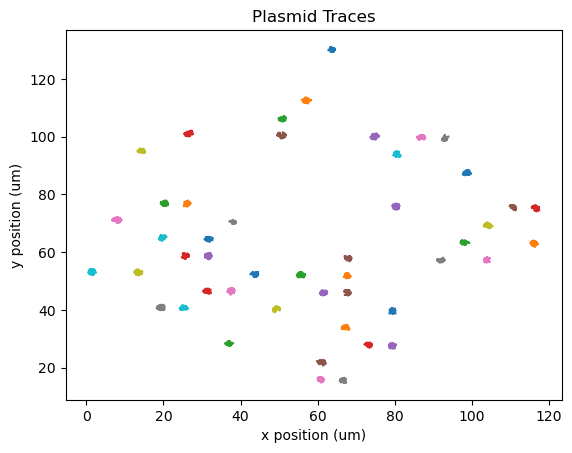


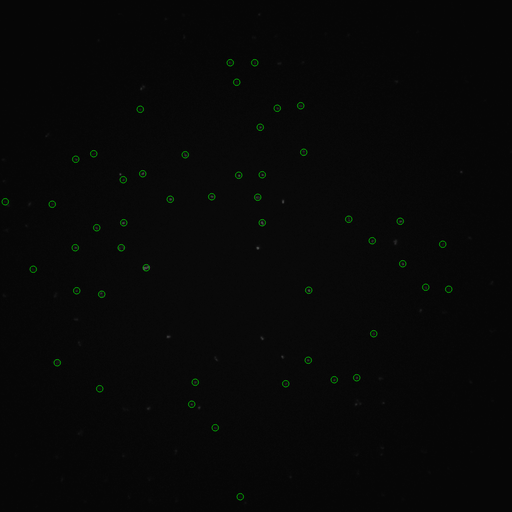

In [7]:
# Track a collection of single particles. Eliminate those that have weak or unrelaible signals (ie splitting)
# or are lost due to imperfect tracking. Also cap the number of tracked particles.

# Manually tuned parameters
threshold_value = 13
min_particle_width = 3
max_particle_width = 25
max_pixel_velocity = 10
p_size = (min_particle_width, max_particle_width)

n_tracked = 50

def track_particles(filepath: str, threshold_value: int, p_size: tuple,
                    max_vel: int, output_graphics: bool, max_tracked: int) -> np.array:
    """
    Returns a 3d numpy array of the particles x and y positions over time (in units of um).
    Generates and displays tracking visualization of selected particles if output_graphics=True.
    """
    
    # Define parameters
    min_particle_width, max_particle_width = p_size

    # Load and normalize frames
    frames = t3a(filepath)
    frames = (frames / frames.max() * 255).astype(np.uint8)

    # Initialize arrays
    prev_positions = np.array([])
    temp_positions = np.array([])
    p_positions = np.array([])
    colour_frames =[]
    gif_frames = []

    # Graphics
    if output_graphics:
        # gif setup
        fps = 20
        output_gif_path = "media/selected_particles.gif"
        frame_width, frame_height = frames[0].shape

    # Main loop
    for f_num, frame in enumerate(frames):
        frame_colour = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR) if output_graphics else None
        colour_frames.append(frame_colour)
        
        # Thresholding and contour detection
        _, binary = cv2.threshold(frame, threshold_value, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # obtain the tracked particle positions
        for contour in contours:
            # filter countours by acceptable area
            c_area = cv2.contourArea(contour)
            if min_particle_width**2 <= c_area <= max_particle_width**2:
                # If particle has acceptable area find its centroid
                M = cv2.moments(contour) 
                if M["m00"] != 0:
                    # store centroid coordinates as cx, cy
                    cx, cy = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
            
                # if this is the first frame store all centroid positions
                if f_num == 0:
                    prev_positions = np.append(prev_positions, [cx, cy]).reshape(-1, 2)
                    temp_positions = np.zeros(prev_positions.shape)
                else:
                    # find the change from closest particle position in the last frame
                    dr_prev = np.sqrt((cx - prev_positions[:, 0]) ** 2 + (cy - prev_positions[:, 1]) ** 2)
                    min_dr = np.min(dr_prev)
                    min_idx = np.argmin(dr_prev)
                    # check if this distance is within the allowed px/frame (max_vel)
                    if min_dr <= max_vel:
                        # assume this is a tracked particle and store its location in the correct row
                        temp_positions[min_idx] = np.array([cx, cy])
        
        # if this is the first frame then set p_positions to all tracked positions
        if f_num == 0:
            p_positions = np.copy(prev_positions)
        # otherwise update p_positions to only include tracked particles
        else:
            # if p_positions only has frame 1 data and is therefore 2D
            if len(p_positions.shape) == 2:
                # mask for valid particle positions
                mask = ~np.all(temp_positions == [0, 0], axis=1)
                # apply mask and reshape positon array
                p_positions = np.append(p_positions[mask], temp_positions[mask])
                p_positions = p_positions.reshape(-1, temp_positions[mask].shape[0], 2)
            # otherwise update 3D array of particle data to only contain tracked particles
            else:
                # mask for valid particle positions
                mask = ~np.all(temp_positions == [0, 0], axis=1)
                # apply mask and reshape positon array
                p_positions = np.append(p_positions[:, mask, :], temp_positions[mask])
                p_positions = p_positions.reshape(-1, temp_positions[mask].shape[0], 2)

            # can now prepare for next iteration by setting prev_positions to the masked temp_positions
            prev_positions = np.copy(temp_positions[mask])
        
        # initialize temp_positions to zero array of shape of prev_postitions
        temp_positions = np.zeros(prev_positions.shape)

    # Graphics
    if output_graphics:   
        for c_frame, p_frame in zip(colour_frames, p_positions[:, :max_tracked, :]):
        
            for pos in p_frame:
                cv2.circle(c_frame, (int(pos[0]), int(pos[1])), 7, (0, 255, 0), 1)
            
            # Prepare GIF frame (resize to 50% for smaller file size)
            rgb_frame = cv2.cvtColor(c_frame, cv2.COLOR_BGR2RGB)
            pil_frame = PILImage.fromarray(rgb_frame).resize(
                (frame_width//2, frame_height//2),  # Half size for PDF compatibility
                resample=PILImage.Resampling.LANCZOS
            )
            gif_frames.append(pil_frame)
        
        # Save GIF
        gif_frames[0].save(
            output_gif_path,
            save_all=True,
            append_images=gif_frames[1:],
            duration=1000//fps,  # ms per frame
            loop=0,
            optimize=True
        )
        print(f"Animated GIF saved as {output_gif_path}")

    return p_positions[:, :max_tracked, :] / 7.64
                    


postions = track_particles("media/ConfinedDNAPlasmids.tif", threshold_value=threshold_value, p_size=p_size,
                           max_vel=max_pixel_velocity, max_tracked=n_tracked, output_graphics=True)
print(postions.shape)

num_particles = postions.shape[1]

for i in range(num_particles):
    x = postions[:, i, 0]
    y = postions[:, i, 1]

    plt.plot(x, y)
plt.title('Plasmid Traces')
plt.xlabel('x position (um)')
plt.ylabel('y position (um)')
plt.show()

with open("media/selected_particles.gif", "rb") as gif_file:
    gif_data = base64.b64encode(gif_file.read()).decode("utf-8")
HTML(f'<img src="data:image/gif;base64,{gif_data}">')

In [8]:
# Calculate D for each particle (using ~linear portion of normal msd and my linearized msd)
# then take the mean and the error to estimate the particle radius

# number of simulations to linearize msd
N = 100
# initialize arrays
linz_D_arr = np.array([])
linz_D_std_arr = np.array([])
con_D_arr = np.array([])
con_D_std_arr = np.array([])

# fit function
def msd_2d(t, D):
    return 4 * D * t

# fit data to find D
def calculate_D(msd):
    p, p_cov = curve_fit(msd_2d, t_arr[:len(msd)], msd)
    p_std = np.sqrt(np.diag(p_cov))
    return p[0], p_std[0]

# calculate uncertainty in mean given a sample and that sample's measurement uncertainties
def sigma_mean(data, data_std):
    return np.sqrt(np.sum(data_std ** 2) / len(data) ** 2 + np.std(data, ddof=1) ** 2 / len(data))

for i in range(num_particles):
    x = postions[:, i, 0]
    y = postions[:, i, 1]
    
    linz_msd = linearized_msd(x, y, N)
    constrained_msd = msd(x, y)
    
    # (most) linear region of constrained diffusion
    lin_con_msd = constrained_msd[:7]

    D_con, D_con_std = calculate_D(lin_con_msd)
    D_lin, D_lin_std = calculate_D(linz_msd)

    # convert to meters
    D_con *= 1E-12
    D_con_std *= 1E-12
    D_lin *= 1E-12
    D_lin_std *= 1E-12

    # append to arrays
    linz_D_arr = np.append(linz_D_arr, D_lin)
    linz_D_std_arr = np.append(linz_D_std_arr, D_lin)
    con_D_arr = np.append(con_D_arr, D_con)
    con_D_std_arr = np.append(con_D_std_arr, D_con)

mean_D_linz, mean_D_std_linz = np.mean(linz_D_arr), sigma_mean(linz_D_arr, linz_D_std_arr)
mean_D_con, mean_D_std_con = np.mean(con_D_arr), sigma_mean(con_D_arr, con_D_std_arr)

print('The diffusion coefficient found from the ~linear portion of '+
      'the constrained diffusion is: D = {:.2e} +/- {:.2e} m^2 /s'.format(mean_D_con, mean_D_std_con))
print('The diffusion coefficient found from my linearization is: '+
      'D = {:.2e} +/- {:.2e} m^2 /s'.format(mean_D_linz, mean_D_std_linz))

The diffusion coefficient found from the ~linear portion of the constrained diffusion is: D = 6.11e-13 +/- 1.36e-13 m^2 /s
The diffusion coefficient found from my linearization is: D = 1.45e-12 +/- 2.15e-13 m^2 /s


## e) ##

In [9]:
eta = 1E-3
T = 22.5 + 273.15
k_b = 1.38E-23

r_con = k_b * T / (6 * np.pi * eta * mean_D_con)
r_con_std = k_b * T * mean_D_std_con / (6 * np.pi * eta * mean_D_con ** 2)
r_lin = k_b * T / (6 * np.pi * eta * mean_D_linz)
r_lin_std = k_b * T * mean_D_std_linz / (6 * np.pi * eta * mean_D_linz ** 2)

print('The estimated radius of the DNA plasmid based on D using confined diffusion data is: '+
      'r = {:.2e} +/- {:.2e} m'.format(r_con, r_con_std))
print('The estimated radius of the DNA plasmid based on D from my linearization method is: '+
      'r = {:.2e} +/- {:.2e} m'.format(r_lin, r_lin_std))

The estimated radius of the DNA plasmid based on D using confined diffusion data is: r = 3.54e-07 +/- 7.88e-08 m
The estimated radius of the DNA plasmid based on D from my linearization method is: r = 1.49e-07 +/- 2.21e-08 m


## f) ##

Sources of error:
- The linear relationship between D and t does not hold for confined diffusion. My attempt at linearization was able to partially correct this, but it did not account for the fact that near the boundary of the well particle diffusion steps are smaller due to collisions with the edge, leading to a smaller diffusion coefficeint than free space thus overestimating plasmid radius.

## g) ##

I have learned how to apply our theoretical framework of diffusion to the real world to measure properties of a system. I learned a lot about computer vision and how it can be used to automate data collection which is particualrly relevant to diffusion experiments.